In [117]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import data from the O*NET database, at ISCO-08 occupation level.
# The original data uses a version of SOC classification, but the data we load here
# are already cross-walked to ISCO-08 using: https://ibs.org.pl/en/resources/occupation-classifications-crosswalks-from-onet-soc-to-isco/

# The O*NET database contains information for occupations in the USA, including
# the tasks and activities typically associated with a specific occupation.

task_data = pd.read_csv("Data\\onet_tasks.csv")
# isco08 variable is for occupation codes
# the t_* variables are specific tasks conducted on the job

# read employment data from Eurostat
# These datasets include quarterly information on the number of workers in specific
# 1-digit ISCO occupation categories. (Check here for details: https://www.ilo.org/public/english/bureau/stat/isco/isco08/)

df = pd.read_excel("Data\\Eurostat_employment_isco.xlsx", sheet_name=None)

# We will focus on three countries, but perhaps we could clean this code to allow it
# to easily run for all the countries in the sample?

# Let's merge all these datasets. We'll need a column that stores the occupation categories:
# Concatenate all sheets horizontally and add an 'ISCO' column
all_data = pd.concat([df[f"ISCO{i}"].assign(ISCO=i) for i in range(1, 10)], ignore_index=True)

# Sample countries
countries = ["Poland", "Spain", "Belgium"]

# Calculate worker totals for each country
totals = all_data.drop(columns = ['ISCO']).groupby('TIME').sum()[countries]
totals = pd.concat([totals] * 9, axis = 0)

# Calculate shares of each occupation among all workers in each country
# totals has "TIME" in index - all_data should as well
all_data.set_index('TIME', inplace = True)

shares = all_data[countries].div(totals, axis=0)
shares.columns = [f'share_{col}' for col in shares.columns]

# Resulting dataframe
all_data = pd.concat([all_data.reset_index(), shares.reset_index(drop = True)], axis = 1)

In [118]:
# Now let's look at the task data. We want the first digit of the ISCO variable only

task_data["isco08_1dig"] = task_data["isco08"].astype(str).str[:1].astype(int)

# And we'll calculate the mean task values at a 1-digit level 
# (more on what these tasks are below)
aggdata = task_data.groupby(["isco08_1dig"]).mean()
aggdata = aggdata.drop(columns=["isco08"])

# We'll be interested in tracking the intensity of Non-routine cognitive analytical tasks
# Using a framework reminiscent of the work by David Autor.

#These are the ones we're interested in:
# Non-routine cognitive analytical
# 4.A.2.a.4 Analyzing Data or Information
# 4.A.2.b.2 Thinking Creatively
# 4.A.4.a.1 Interpreting the Meaning of Information for Others

#Let's combine the data.
combined = pd.merge(all_data, aggdata, left_on='ISCO', right_on='isco08_1dig', how='left')
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us:

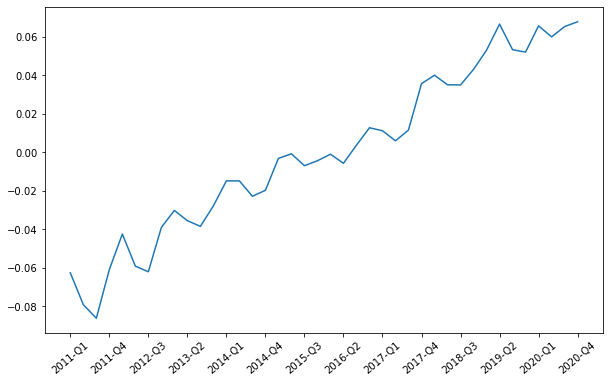

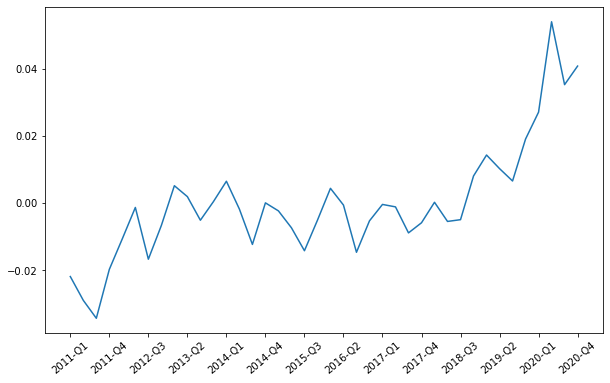

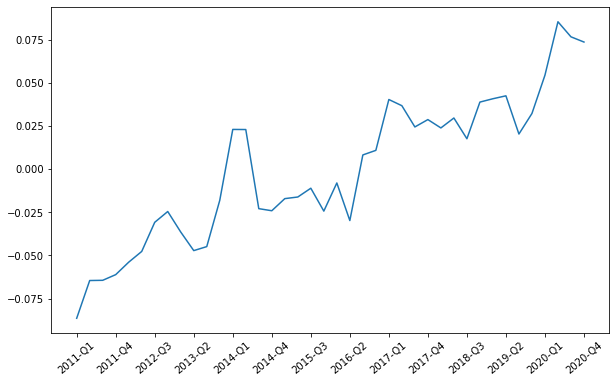

In [131]:
# Traditionally, the first step is to standardise the task values using weights 
# defined by share of occupations in the labour force. This should be done separately
# for each country. Standardisation -> getting the mean to 0 and std. dev. to 1.
# Let's do this for each of the variables that interests us

def calculate_standardized_columns(df, countries, var_list):   
    for var in var_list:
        for country in countries:
            share_col = f"share_{country}"
            std_col = f"std_{country}_{var}"
            temp_mean = np.average(df[var], weights=df[share_col])
            temp_sd = np.sqrt(np.average((df[var] - temp_mean) ** 2, weights=df[share_col]))
            df[std_col] = (df[var] - temp_mean) / temp_sd
            
    return df

# Define variables to be standardized
var_list = ["t_4A2a4", "t_4A2b2", "t_4A4a1"]

# Standardize columns for each variable and country
combined = calculate_standardized_columns(combined, countries, var_list)


# The next step is to calculate the `classic` task content intensity, i.e.
# how important is a particular general task content category in the workforce
# Here, we're looking at non-routine cognitive analytical tasks, as defined
# by David Autor and Darron Acemoglu and standardise in a similar way

def calculate_NRCA(df, countries, var_list):
    for country in countries:
        df[f"{country}_NRCA"] = df[[f"std_{country}_{var}" for var in var_list]].sum(axis=1)
        temp_mean = np.average(df[f"{country}_NRCA"], weights=df[f"share_{country}"])
        temp_sd = np.sqrt(np.average((df[f"{country}_NRCA"] - temp_mean) ** 2, weights=df[f"share_{country}"]))
        df[f"std_{country}_NRCA"] = (df[f"{country}_NRCA"] - temp_mean) / temp_sd
        df[f"multip_{country}_NRCA"] = df[f"std_{country}_NRCA"] * df[f"share_{country}"]
    agg = []
    for country in countries:
        agg.append(df.groupby(["TIME"])[f"multip_{country}_NRCA"].sum())
    final_df = pd.concat(agg, axis = 1)
    return final_df

# Calculate country-level NRCA
agg = calculate_NRCA(combined, countries, var_list)

# Plot by country:
for var in agg.columns:
    plt.figure(figsize =  (10, 6))
    plt.plot(agg[var])
    plt.xticks(range(0, len(agg.index), 3), agg.index[::3], rotation = 40)
    plt.show()